Current bandit is LinUCB
Current bandit is LinThompSamp
Current bandit is UCB1
Current bandit is Exp3
Current bandit is random


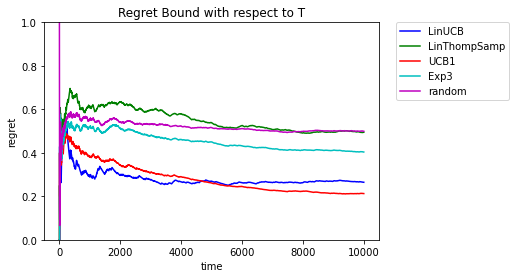

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from striatum.storage import history
from striatum.storage import model
from striatum.storage import (
    MemoryHistoryStorage,
    MemoryModelStorage,
    MemoryActionStorage,
    Action,
)
from striatum.bandit import ucb1
from striatum.bandit import linucb
from striatum.bandit import linthompsamp
from striatum.bandit import exp4p
from striatum.bandit import exp3
#from striatum.bandit.bandit import Action
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


def get_data():
    """
    get data from csv files
    Returns: streaming_batch, user_feature, actions, reward_list, action_context
    """
    # streaming_batch = pd.read_csv(
    #     'streaming_batch.csv', sep='\t', names=['user_id'], engine='c')
    streaming_batch = pd.read_csv(
        'C:/Users/seunghwa/Desktop/ml-1m/ml-1m/streaming_batch.csv', sep='\t', header=0, engine='c') # 去掉首行数据
    user_feature = pd.read_csv(
        'C:/Users/seunghwa/Desktop/ml-1m/ml-1m/user_feature.csv', sep='\t', header=0, index_col=0, engine='c')
    actions_id = list(
        pd.read_csv('C:/Users/seunghwa/Desktop/ml-1m/ml-1m/actions.csv', sep='\t', header=0, engine='c')['movie_id'])
    reward_list = pd.read_csv(
        'C:/Users/seunghwa/Desktop/ml-1m/ml-1m/reward_list.csv', sep='\t', header=0, engine='c')
    action_context = pd.read_csv(
        'C:/Users/seunghwa/Desktop/ml-1m/ml-1m/action_context.csv', sep='\t', header=0, engine='c')

    tempactions = []
    for key in actions_id:
        action = Action(key)
        tempactions.append(action)
    actions = MemoryActionStorage()
    actions.add(tempactions)
    return streaming_batch, user_feature, actions, reward_list, action_context

# action_context는 top50의 액션의 장르는 무슨장르인지
def train_expert(action_context):
    logreg = OneVsRestClassifier(LogisticRegression())
    mnb = OneVsRestClassifier(MultinomialNB(), )
    logreg.fit(action_context.iloc[:, 2:], action_context.iloc[:, 1])
    mnb.fit(action_context.iloc[:, 2:], action_context.iloc[:, 1])
    return [logreg, mnb]


def get_advice(context, actions_id, experts):
    advice = {}
    for time in context.keys():
        advice[time] = {}
        for i in range(len(experts)):
            prob = experts[i].predict_proba(context[time])[0]
            advice[time][i] = {}
            for j in range(len(prob)):
                advice[time][i][actions_id[j]] = prob[j]
    return advice


def policy_generation(bandit, actions):
    """
    Parameters
    ----------
    bandit： 赌博机算法
    actions：动作即推荐的电影
    Returns
    -------
    policy： 生成的策略
    """
    historystorage = history.MemoryHistoryStorage()  # 内存中历史存储记录
    modelstorage = model.MemoryModelStorage()   # 内存中模型存储，为了统一

    if bandit == 'Exp4P':
        policy = exp4p.Exp4P(
            historystorage, modelstorage, actions, delta=0.5, p_min=None)

    elif bandit == 'LinUCB':
        #policy = linucb.LinUCB(historystorage, modelstorage, actions, 0.3, 20)
        policy = linucb.LinUCB(history_storage = historystorage, model_storage = modelstorage,action_storage = actions, alpha = 0.3, context_dimension = 18)

    elif bandit == 'LinThompSamp':
        policy = linthompsamp.LinThompSamp(
            historystorage,
            modelstorage,
            actions,
            #d=20, Supposed to be context dimension
            context_dimension=18,
            delta=0.61,
            R=0.01,
            epsilon=0.71)

    elif bandit == 'UCB1':
        policy = ucb1.UCB1(historystorage, modelstorage, actions)

    elif bandit == 'Exp3':
        policy = exp3.Exp3(historystorage, modelstorage, actions, gamma=0.2)

    elif bandit == 'random':
        policy = 0

    return policy

# 策略评估
def policy_evaluation(policy,
                      bandit,
                      streaming_batch,
                      user_feature,
                      reward_list,
                      actions,
                      action_context=None):
    times = len(streaming_batch)
    seq_error = np.zeros(shape=(times, 1))
    #actions_id = [actions[i].action_id for i in range(len(actions))]
    actions_id = [action_id for action_id in actions.iterids()]
    if bandit in ['LinUCB', 'LinThompSamp', 'UCB1', 'Exp3']:
        for t in range(0, times):
            # print(user_feature.index)
            # print(streaming_batch.iloc[t, 0])
            # print(user_feature.index == streaming_batch.iloc[t, 0])
            # feature_list = np.array(user_feature[user_feature.index ==
            #                                 streaming_batch.iloc[t, 0]])
            # print(feature_list)
            # if feature_list == []:
            #     continue
            feature = np.array(user_feature[user_feature.index ==
                                            streaming_batch.iloc[t, 0]])[0]
            full_context = {}
            for action_id in actions_id:
                full_context[action_id] = feature
            # Get only 1 action
            #history_id, action = policy.get_action(full_context, 1)
            history_id, action = policy.get_action(full_context, None)
            watched_list = reward_list[reward_list['user_id'] ==
                                       streaming_batch.iloc[t, 0]]

            #if action[0]['action'].action_id not in list(
            if action.action.id not in list(watched_list['movie_id']):
                #policy.reward(history_id, {action[0]['action'].action_id: 0.0})
                policy.reward(history_id, {action.action.id: 0.0})
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0

            else:
                policy.reward(history_id, {action.action.id: 1.0})
                if t > 0:
                    seq_error[t] = seq_error[t - 1]

    elif bandit == 'Exp4P':
        for t in range(times):
            feature = user_feature[user_feature.index == streaming_batch.iloc[
                t, 0]]
            # LOO, very slow!
            experts = train_expert(action_context)
            advice = {}
            for i in range(len(experts)):
                prob = experts[i].predict_proba(feature)[0]
                advice[i] = {}
                for j in range(len(prob)):
                    advice[i][actions_id[j]] = prob[j]
            history_id, action = policy.get_action(advice)
            watched_list = reward_list[reward_list['user_id'] ==
                                       streaming_batch.iloc[t, 0]]

            #if action[0]['action'].id not in list(watched_list['movie_id']):
            if action[0].action.id not in list(watched_list['movie_id']):
                policy.reward(history_id, {action[0].action.id: 0.0})
                #policy.reward(history_id, {action[0]['action'].id: 0.0})
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0

            else:
                #policy.reward(history_id, {action[0]['action'].action_id: 1.0})
                policy.reward(history_id, {action[0].action.id: 1.0})
                if t > 0:
                    seq_error[t] = seq_error[t - 1]

    elif bandit == 'random':
        for t in range(times):
            action = actions_id[np.random.randint(0, len(actions_id) - 1)]
            watched_list = reward_list[reward_list['user_id'] ==
                                       streaming_batch.iloc[t, 0]]

            if action not in list(watched_list['movie_id']):
                if t == 0:
                    seq_error[t] = 1.0
                else:
                    seq_error[t] = seq_error[t - 1] + 1.0

            else:
                if t > 0:
                    seq_error[t] = seq_error[t - 1]

    return seq_error


def regret_calculation(seq_error):
    t = len(seq_error)
    regret = [x / y for x, y in zip(seq_error, range(1, t + 1))]
    return regret


def main():
    streaming_batch, user_feature, actions, reward_list, action_context = get_data()
    streaming_batch_small = streaming_batch.iloc[0:10000] # 取前10000条数据

    # conduct regret analyses
    #experiment_bandit = [
    #    'LinUCB', 'LinThompSamp', 'Exp4P', 'UCB1', 'Exp3', 'random'
    #]
    experiment_bandit = [
        'LinUCB',
        'LinThompSamp',
        # 'Exp4P', # Takes very long as train expert is LOO Cross Validation
        'UCB1',
        'Exp3',
        'random'
    ]
    regret = {} # 累计遗憾
    col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    i = 0
    for bandit in experiment_bandit:
        print("Current bandit is", bandit)
        policy = policy_generation(bandit, actions)  # generate policy
        seq_error = policy_evaluation(policy, bandit, streaming_batch_small,
                                      user_feature, reward_list, actions,
                                      action_context)
        regret[bandit] = regret_calculation(seq_error)
        plt.plot(
            range(len(streaming_batch_small)),
            regret[bandit],
            c=col[i],
            ls='-',
            label=bandit)
        plt.xlabel('time')
        plt.ylabel('regret')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        axes = plt.gca()
        axes.set_ylim([0, 1])
        plt.title("Regret Bound with respect to T")
        i += 1
    plt.show()


if __name__ == '__main__':
    main()

In [ ]:
train_expert(action_context)

In [ ]:
ads